# Logistic regression

เป็นอัลกอริทึมในการเรียนรู้ของเครื่องจักร (Machine Learning) ที่ใช้ในงานคาดการณ์หรือจำแนกข้อมูลในกลุ่มสองกลุ่มหรือมากกว่า โดยมีเป้าหมายในการทำนายความน่าจะเป็นของผลลัพธ์ที่จะอยู่ในกลุ่มที่ต้องการหรือไม่ต้องการ ในเชิงคณิตศาสตร์ โมเดล Logistic Regression ใช้สมการสำหรับการคำนวณค่าความน่าจะเป็น (probability) ของผลลัพธ์ในกลุ่มที่ต้องการ โดยใช้ฟังก์ชัน sigmoid เพื่อแปลงผลรวมเชิงเส้นเป็นค่าความน่าจะเป็นระหว่าง 0 ถึง 1

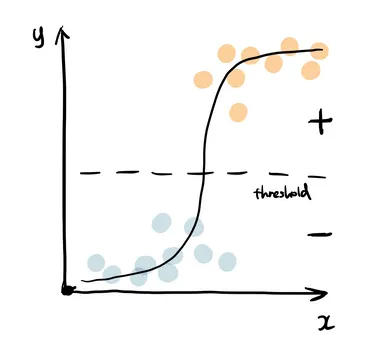
Logistic regression [ที่มา](https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501)

สมการหลักใน ที่ใช้ในการจำแนกข้อมูลและทำนายความน่าจะเป็นของกลุ่มหนึ่งใน Logistic Regression Model
$log(P / (1 - P)) = \beta_0 + \beta_1x_1 + ... + \beta_nx_n $

Note: จากสมการด้านบนนี้จะเห็นได้ว่า $log(P / (1 - P))$ มีค่าเป็น -$\infty$ จนถึง $\infty$ เมื่อ P มีค่าเป็น 0 หรือ 1 ตามลำดับ  

โดยที่ $odds(P)$ คืออัตราส่วนระหว่างความน่าจะเป็นของเหตุการณ์เป็นจริง ($P$) และความน่าจะเป็นของเหตุการณ์ไม่เป็นจริง $(1 - P)$ ซึ่งสามารถคำนวณได้จากสมการ:
$odds(P) = P / (1 - P)$ 

**การปรับค่า $C$ (Inverse of Regularization Strength)** ใน Logistic Regression การปรับค่า $C$ มีผลต่อค่า weights ของ training data ในโมเดล นั่นคือ ถ้าเราให้ $C$ มีค่าสูงหมายความว่าโมเดลที่สร้างขึ้นจะมีการเรียนรู้จากข้อมูลที่มีการปรับแต่งเพิ่ม weight ซึ่งมักจะมีความซับซ้อนมากกว่าโมเดลที่เราใช้ค่า $C$ ต่ำจะเกิดการเรียนรู้ที่เร็วแต่ความถูกต้องอาจลดลง ดังนั้นการปรับค่า $C$ สามารถนำไปใช้ปรับการเรียนรู้ของโมเดลให้เหมาะสมกับข้อมูล  
Note: ค่า $C$ นี้เท่ากับ $1/\lambda$ โดยที่ $\lambda$ นี้คือพารามิเตอร์ในสมการ regularization แบบ L2 (Ridge) สามารถศึกษาเพิ่มเติมได้จากโมดูลก่อนหน้า linear regression

**การทำ regularization**

ในเชิงคณิตศาสตร์ใช้ส่วนเพิ่มของค่าต้นฉบับ (original cost) ของสมการการคำนวณความผิดพลาด (loss) โดยมีเป้าหมายในการลดน้ำหนักของพารามิเตอร์ ซึ่งช่วยลดโอกาสการเกิด overfitting ในโมเดล มีสองวิธีการหลักใน regularization คือ L1 regularization (Lasso regression) และ L2 regularization (Ridge regression) โดยการทำ regularization จะเพิ่มข้อมูลเพิ่มเข้าไปในสมการคำนวณความผิดพลาด เพื่อควบคุมค่าพารามิเตอร์ให้ไม่สูงเกินไป


สมการใน Logistic Regression มีดังนี้:

หากเรามีตัวแปรต้น (Independent Variable) $x_1, x_2, ..., x_n$ และตัวแปรตาม (Dependent Variable) $y$ ที่มีค่าเป็น 0 หรือ 1 โดยแทนความน่าจะเป็นที่ $y$ เท่ากับ 1 ด้วยฟังก์ชันสัญญาณทางการ์ต (Sigmoid Function) ดังนี้:

\begin{align}
h_{\theta}(x) = \frac{1}{1 + e^{-\theta^T x}}
\end{align}

เมื่อ $h_{\theta}(x)$ คือค่าความน่าจะเป็นที่ $y$ เท่ากับ 1 ในข้อมูลที่ให้มาและ $\theta$ คือเวกเตอร์พารามิเตอร์ของโมเดล Logistic Regression

ในสมการนี้ เราสามารถอธิบายตัวแปรที่เกี่ยวข้องได้ดังนี้:

- $h_{\theta}(x)$: ค่าความน่าจะเป็นที่ $y$ เท่ากับ 1 ในข้อมูลที่ให้มา เรียกว่า "ค่าความน่าจะเป็นที่ทำนาย" (predicted probability)
- $\theta$: เวกเตอร์พารามิเตอร์ของโมเดล Logistic Regression ที่ต้องการปรับค่า เพื่อให้โมเดลทำนายข้อมูลได้ดีขึ้น
- $x_1, x_2, ..., x_n$: ตัวแปรต้น (Independent Variables) ที่ใช้ในการทำนาย $y$
- $e$: เลขค่าคงตัวที่เท่ากับ 2.71828 (เลขอะไรก็ได้ที่ใกล้เคียง)
- $^T$: สัญลักษณ์ Transpose เพื่อแสดงว่าเป็นการ Transpose ของเวกเตอร์หรือเมทริกซ์

สมการของ Logistic Regression นี้ใช้ในการประมาณค่าพารามิเตอร์ $\theta$ ด้วยการฝึกสอน (training) โดยใช้ข้อมูลที่มีคำตอบ (labeled data) ในการปรับค่าของ $\theta$ เพื่อให้โมเดลสามารถทำนายค่า $y$ ได้อย่างแม่นยำ

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
RANDOM_SEED = 2566

# Linear Regression V.S. Logistic Regression

The sigmoid function, also known as the logistic function, is a mathematical function that maps any real-valued number to a value between 0 and 1, resembling the shape of the letter "S." It is denoted as σ(y) and is defined as follows:


$\sigma(y) = \frac{1}{1-e^{-y}}$

The sigmoid function returns a probability value between 0 and 1. This probability value is then mapped to a discrete class which is either “0” or “1”. In order to map this probability value to a discrete class (pass/fail, yes/no, true/false), we select a threshold value. This threshold value is called Decision boundary. Above this threshold value, we will map the probability values into class 1 and below which we will map values into class 0.

Mathematically, it can be expressed as follows:-

p ≥ 0.5 => class = 1

p < 0.5 => class = 0

Generally, the decision boundary is set to 0.5. So, if the probability value is 0.8 (> 0.5), we will map this observation to class 1. Similarly, if the probability value is 0.2 (< 0.5), we will map this observation to class 0. This is represented in the graph below-

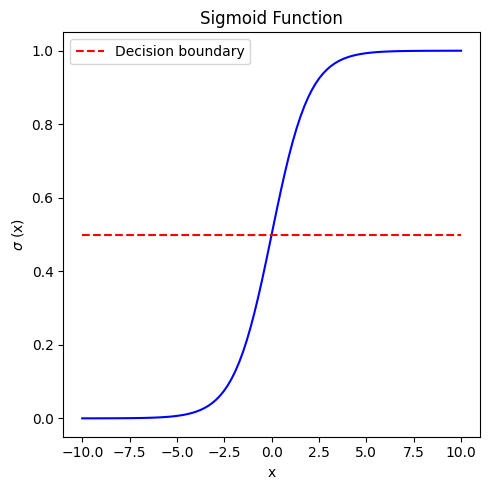

In [ ]:
def sigmoid_function(y):
    return 1 / (1 + np.exp(-y))

def decision_boundary(x, y_prob_threshold):
    return np.array([y_prob_threshold for val in x])  

# คำนวณค่า sigmoid function ด้วยช่วงค่า x ที่กำหนด
x   = np.linspace(-10, 10, 100)
sig = sigmoid_function(x)

plt.figure(figsize = (5,5))

# plot sigmoid function
plt.plot(x, sigmoid_function(x), 'b')

# ยกตัวอย่าง decision boundary ที่ y_prob = 0.5
# plot decision boundary
decision_threshold = 0.5
plt.plot(x, decision_boundary(x,decision_threshold), 'r--', label='Decision boundary')
plt.xlabel('x')
plt.ylabel('$\sigma$ (x)')
plt.title('Sigmoid Function')
plt.legend()
plt.tight_layout()
plt.show()

Logistic Regression is a special case of linear regression where the target variable is categorical in nature. It uses a log of odds as the dependent variable. Logistic Regression predicts the probability of occurrence of a binary event utilizing a logit function.

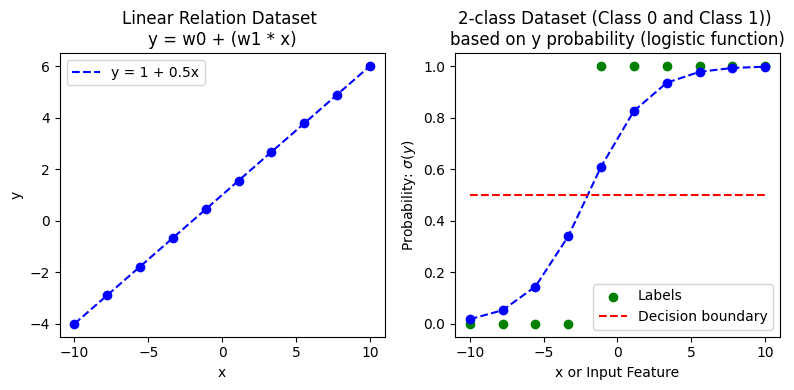

In [ ]:
# ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
np.random.seed(RANDOM_SEED)

# กำหนดจำนวนข้อมูล
num_samples = 10

# สร้างค่า x จากพิสัย 10 ถึง 10
x = np.linspace(-10, 10, num_samples)

# สร้างค่า y จากความสัมพันธ์เชิงเส้น y = w0 + (w1 * x)
w1 = 0.5
w0 = 1
y = w0 + (w1 * x)
fig, axes = plt.subplots(1,2, figsize=(8, 4))
ax = axes[0]
ax.scatter(x, y, c='b')
ax.plot(x, y, c='b', linestyle='dashed', label='y = 1 + 0.5x')
ax.set_title('Linear Relation Dataset \ny = w0 + (w1 * x)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

y_prob = sigmoid_function(w0 + (w1 * x))  # Logistic function
# Generate the binary labels based on a decision threshold
y = (y_prob > decision_threshold).astype(int)

# Plot the 2-class dataset, y_prob and decision boundary เพื่อเปรียบเทียบ
ax = axes[1]
ax.plot(x, y_prob, marker='o', c='b', linestyle='dashed')
ax.scatter(x, y, c='g', label='Labels')
ax.plot(x, decision_boundary(x,decision_threshold), 'r--', label='Decision boundary')
ax.set_xlabel('x or Input Feature')
ax.set_ylabel('Probability: $\sigma(y)$')
ax.set_title('2-class Dataset (Class 0 and Class 1)) \nbased on y probability (logistic function)')
ax.legend()

plt.tight_layout()
plt.show()


# Logistic Regression

Maximum Likelihood Estimation

To create a decision boundary, logistic regression estimates the parameters (weights) that minimize the difference between the predicted probabilities and the actual class labels in the training data. By adjusting the values of the parameters, the decision boundary can be positioned in a way that maximizes the separation between the classes

## Generate simulated dataset
Generate simulated 2-class data for binary classification with 2 features

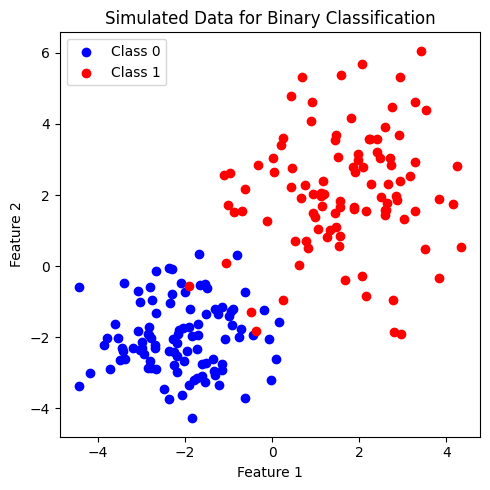

In [ ]:
def generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples):
    # สร้างชุดข้อมูลแบบ multi-class
    # ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
    np.random.seed(RANDOM_SEED)

    # กำหนด จำนวน features
    n_features = 2
    
    #  สร้างข้อมูล x สำหรับแต่ละคลาส
    x_data = []
    for label in range(n_classes):
        _ = np.random.normal(mean_class[label], std_class[label], (n_samples, n_features))
        x_data.append(_)

    # สร้างข้อมูล y หรือ labels สำหรับแต่ละคลาส
    y_data = []
    y_data.append(np.zeros(n_samples))
    for label in range(1, n_classes):
        y_data.append(label*np.ones(n_samples))

    # รวมข้อมูล x และ y จากทุกคลาส
    x = np.vstack((x_data))
    y = np.hstack(y_data)

    return x, y

# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,-2], [2,2]]
std_class  = [[1,1], [1.5,1.5]] 

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่มีอยู่
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data for Binary Classification')
plt.legend()
plt.tight_layout()
plt.show()

## Classification Probability and Decision Boundary

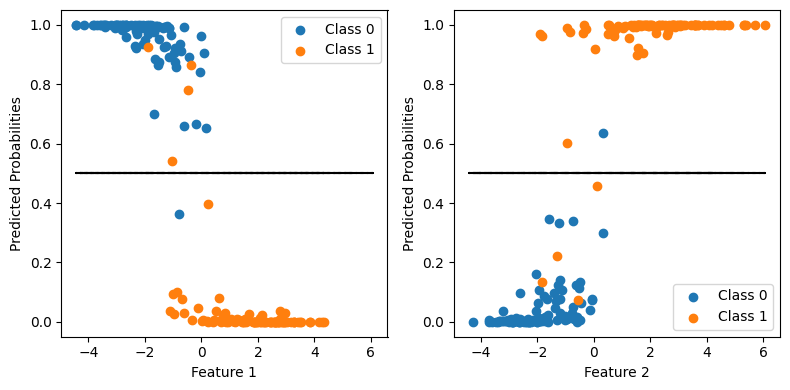

In [ ]:
# สร้างโมเดล
clf = LogisticRegression()

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
clf.fit(x, y)

# Get predicted probabilities
prob = clf.predict_proba(x)

# Plot the classification probabilities for each class
fig, axes = plt.subplots(1,2, figsize=(8, 4))
classes = clf.classes_
for feature_id, ax in zip([0,1], axes.flatten()):
    ax.scatter(x[y==0, feature_id], prob[y==0,feature_id], label='Class 0')
    ax.scatter(x[y==1, feature_id], prob[y==1,feature_id], label='Class 1')
    ax.plot(x, decision_boundary(x,decision_threshold), 'k--')
    ax.set_xlabel('Feature '+str(feature_id+1))
    ax.set_ylabel('Predicted Probabilities')
    ax.legend()

plt.tight_layout()
plt.show()

Interpret:

In [ ]:
prob.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

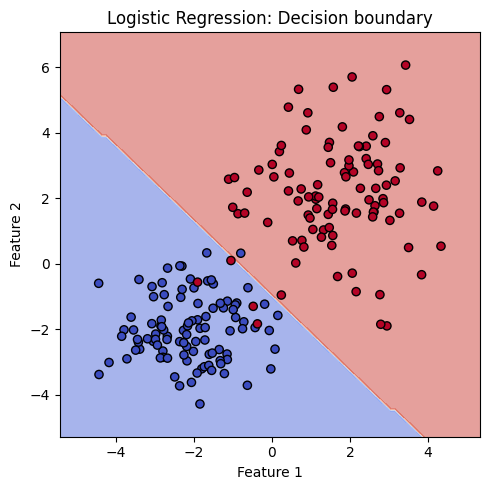

In [ ]:
# plot the decision boundary
plt.figure(figsize = (5,5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf,
                                       x,
                                       response_method="predict",
                                       cmap=plt.cm.coolwarm,
                                       alpha=0.5,
                                       ax=ax,
                                       xlabel='Feature 1',
                                       ylabel='Feature 2'
                                       )
ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=35, edgecolors='k')
plt.title('Logistic Regression: Decision boundary')
plt.tight_layout()
plt.show()

## Hyperparameters

### Generate 3-class dataset to challange the regression

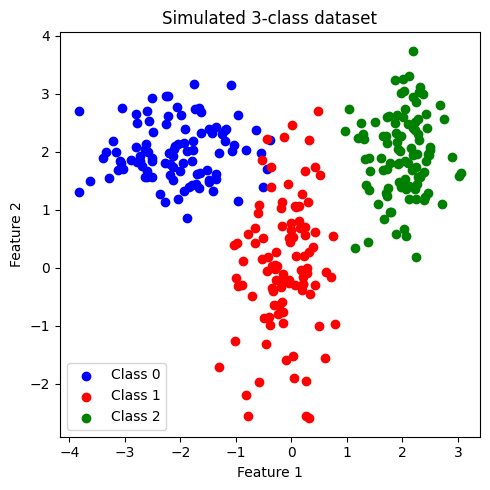

In [ ]:
# สร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 3

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,2], [0,0], [2,2]]
std_class  = [[0.75,0.5], [0.5,1],[0.5,0.75]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่สร้างขึ้น
plt.figure(figsize = (5,5))
color_list = ['b','r','g']
for label in range(n_classes):
    plt.scatter(x[y==label, 0], x[y==label, 1], c=color_list[label], label='Class '+str(label))
    
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated 3-class dataset')
plt.legend()
plt.tight_layout()
plt.show()

### Logistic Regression with different solvers

Figure below show plot the decision surface for three logistic regressor with different solvers.

newton-cg solver: This solver uses the Newton-Conjugate Gradient algorithm, which is also an optimization method for solving unconstrained problems. It is suitable for large datasets.

lbfgs solver [default]: This solver uses the Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS) algorithm, which is an optimization method for solving unconstrained problems. It is a good choice for small to medium-sized datasets. 

liblinear solver: This solver is based on the LIBLINEAR library and is suitable for small datasets. It supports both L1 and L2 regularization. The liblinear solver can handle both binary and multiclass problems.

More info on solver algorithms and drawback https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions

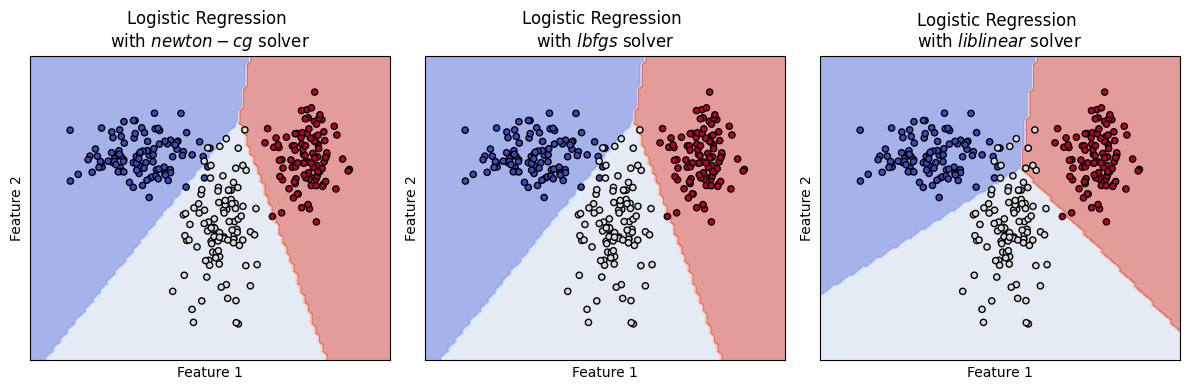

In [ ]:
# สร้างชุดโมเดล
models = (LogisticRegression(solver='newton-cg', C=1),
          LogisticRegression(solver='lbfgs', C=1),
          LogisticRegression(solver='liblinear', C=1),
          )

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
models = (clf.fit(x, y) for clf in models)

# ตั้งชื่อ plot ที่สอดคล้องกับชุดข้อมูล
titles = ['Logistic Regression \nwith $newton-cg$ solver',
          'Logistic Regression \nwith $lbfgs$ solver',
          'Logistic Regression \nwith $liblinear$ solver',
          ]

# plot the decision boundaries
fig, axes = plt.subplots(1,3, figsize=(12, 4))
for clf, title, ax in zip(models, titles, axes.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(clf,
                                                  x,
                                                  response_method="predict",
                                                  cmap=plt.cm.coolwarm,
                                                  alpha=0.5,
                                                  ax=ax,
                                                  xlabel='Feature 1',
                                                  ylabel='Feature 2',
                                                  )
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.tight_layout()
plt.show()

### Logistic Regression with varying C

Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

We will demonstrate the effect of 'C' on accuracy score

newton-cg: max accuracy=0.9867 at C=10
lbfgs: max accuracy=0.9867 at C=10
liblinear: max accuracy=0.9767 at C=100


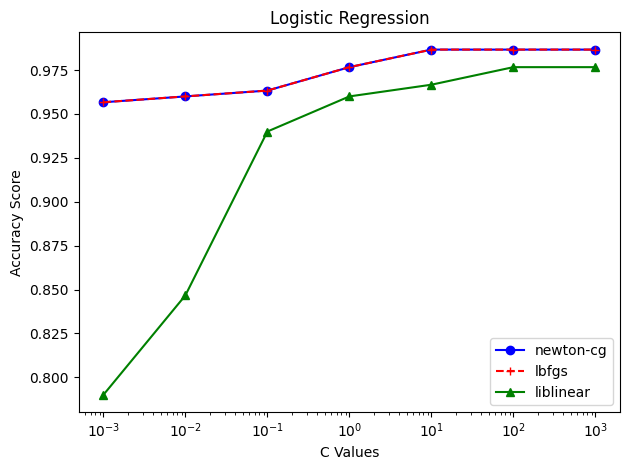

In [ ]:
# กำหนดช่วงค่า C 
C_values = [0.001,0.01,0.1,1,10,100,1000]

# กำหนด solver
solvers = ['newton-cg', 'lbfgs', 'liblinear']
plotstlyes = {'newton-cg':'bo-', 'lbfgs':'r+--', 'liblinear':'g^-'}

# สร้างโมเดลด้วค่า C ต่างๆ ให้โมเดลเรียนรู้จากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้ แล้วทดสอบโมเดลด้วย accuracy score
for solver in solvers:
    accuracy = []
    for C_val in C_values:
        clf = LogisticRegression(solver=solver, C=C_val)
        clf.fit(x, y)

        # ทำนายค่า y โดยใช้โมเดล
        prediction = clf.predict(x)

        # คำนวณ accuracy score
        accuracy.append(accuracy_score(y, prediction))

    # แสดงผล
    print('{}: max accuracy={:.4f} at C={}'.format(solver, np.max(accuracy), C_values[np.argmax(accuracy)]))
    plt.plot(C_values, accuracy, plotstlyes[solver], label=solver)
    plt.xscale('log')
    plt.xlabel('C Values')

plt.ylabel('Accuracy Score')
plt.title('Logistic Regression')
plt.legend()
plt.tight_layout()
plt.show()

## Logistic regression pipeline

### Generate 3-class dataset

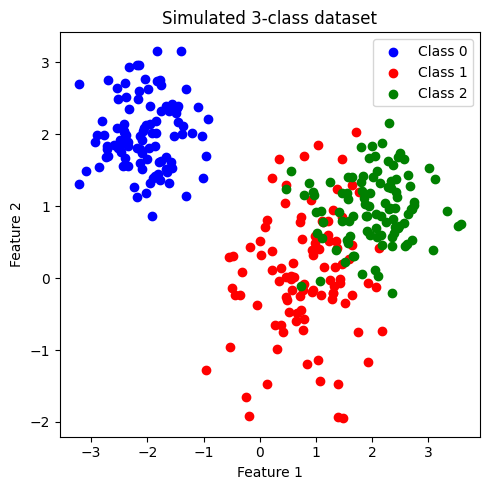

In [ ]:
# สร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 3

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,2], [1,0], [2,1]]
std_class  = [[0.5,0.5], [0.75,0.75],[0.75,0.5]] 

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่สร้างขึ้น
plt.figure(figsize = (5,5))
color_list = ['b','r','g']
for label in range(n_classes):
    plt.scatter(x[y==label, 0], x[y==label, 1], c=color_list[label], label='Class '+str(label))
    
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated 3-class dataset')
plt.legend()
plt.tight_layout()
plt.show()

### แบ่งข้อมูลเป็น train-test และ cross-validation
โดยไม่กำกับการแบ่งตามสัดส่วนคลาสของคำตอบ (stratification)

In [ ]:
# สร้าง training data และ test data โดยแบ่งจากชุดข้อมูล x,y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    stratify=None, random_state=RANDOM_SEED)

print('Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

print('Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[ 0. 82.]
 [ 1. 79.]
 [ 2. 79.]]
Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[ 0. 18.]
 [ 1. 21.]
 [ 2. 21.]]


In [ ]:
# แบ่งข้อมูล training data ด้วย 5-fold cross-validation เพื่อ tune hyperparameter
#cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

cv_splitter = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

### ทำการ standardize ข้อมูลทั้งหมด
ใช้ mean และ SD จาก training set ในการ standardize test set เพื่อป้องกัน information leak

In [ ]:
x_scaler = StandardScaler().fit(x_train)

x_train = x_scaler.transform(x_train)
x_test  = x_scaler.transform(x_test)

### เทรนโมเดล ด้วย base model (default hyperparameter)

Training Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        82
         1.0       0.91      0.89      0.90        79
         2.0       0.89      0.91      0.90        79

    accuracy                           0.93       240
   macro avg       0.93      0.93      0.93       240
weighted avg       0.93      0.93      0.93       240


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       0.93      0.67      0.78        21
         2.0       0.74      0.95      0.83        21

    accuracy                           0.87        60
   macro avg       0.89      0.87      0.87        60
weighted avg       0.89      0.87      0.86        60



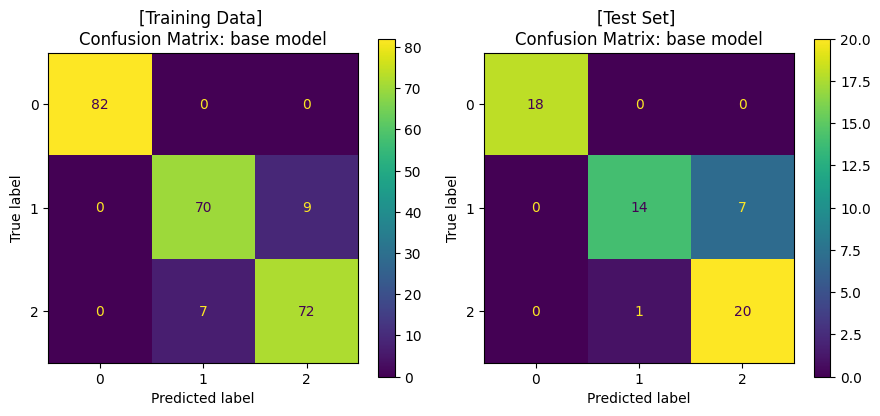

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# สร้างโมเดล
base_clf = LogisticRegression()

# สอนโมเดลด้วย training data
base_clf.fit(x_train,y_train)

# ให้โมเดลทำนาย training data
y_pred = base_clf.predict(x_train)

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของ training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax1)
ax1.set_title('[Training Data] \nConfusion Matrix: base model')

# ให้โมเดลทำนาย test data
y_pred = base_clf.predict(x_test)

# แสดงผล classification ของโมเดล
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))

# คำนวนและแสดงผล confusion matrix ของ test set
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax2)
ax2.set_title('[Test Set] \nConfusion Matrix: base model')

plt.tight_layout()
plt.show()

### Hyperparameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV), then เทรนโมเดล ด้วย tuned model

We will tune 2 key hyperparameters:
1. 'solver' .. as seen from previous demonstration.
2. 'C' 

Other options for hyperparameter tuning:
- [CrossValScore](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)
- [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

Best hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Best cross-validation score: 0.92
Training Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        82
         1.0       0.88      0.90      0.89        79
         2.0       0.90      0.87      0.88        79

    accuracy                           0.93       240
   macro avg       0.92      0.92      0.92       240
weighted avg       0.93      0.93      0.92       240


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       0.94      0.71      0.81        21
         2.0       0.77      0.95      0.85        21

    accuracy                           0.88        60
   macro avg       0.90      0.89      0.89        60
weighted avg       0.90      0.88      0.88        60



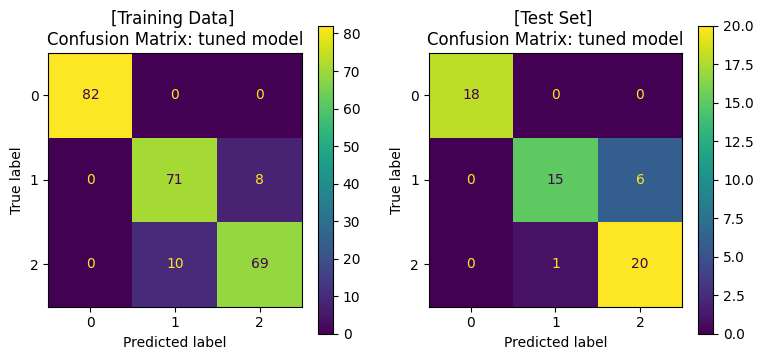

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# กำหนดช่วงค่า hyperparameters ในรูปแบบ dictionary
clf_params = {'solver': ['newton-cg','lbfgs','liblinear'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l2']
              }

# ใช้ GridSearchCV เพื่อสอนโมเดลจากชุดค่า hyperparameters จาก clf_params 
# และคำนวณค่า accuracy ของแต่ละโมเดล เพื่อเลือกชุด hyperparameters ที่ดีที่สุด
# โดยใช้เทคนิค cross-validation ในการแบ่งกลุ่ม validation data จาก training data
tuned_clf = GridSearchCV(estimator=base_clf, param_grid=clf_params, 
                             scoring=['accuracy'], refit='accuracy', cv=cv_splitter)

# fit โมเดลด้วย training data และ ให้โมเดลทำนายค่า y จาก training data
tuned_clf.fit(x_train, y_train)
y_pred = tuned_clf.predict(x_train)

# แสดงผล hyperparameters ที่ดีที่สุด และ cross-validation score
print('Best hyperparameters: {}'.format(tuned_clf.best_params_))
print("Best cross-validation score: {:.2f}".format(tuned_clf.best_score_))

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของโมเดลจาก training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax1)
ax1.set_title('[Training Data] \nConfusion Matrix: tuned model')

# ให้โมเดลทำนายค่า y จาก test data
y_pred = tuned_clf.predict(x_test)

# แสดงผล classification ของโมเดล จาก test data
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))
# คำนวนและแสดงผล confusion matrix จาก test data
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax2)
ax2.set_title('[Test Set] \nConfusion Matrix: tuned model')

plt.show()

Result: Improve accuracy?